

This project applies unsupervised learning techniques to explore and understand a large corpus of text data — the 20 Newsgroups dataset — using both KMeans clustering and Latent Dirichlet Allocation (LDA).




1: Install Dependencies

In [ ]:

!pip install -U gensim pyLDAvis wordcloud nltk seaborn matplotlib scikit-learn --quiet

2: Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
import nltk
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import multiprocessing
from joblib import Parallel, delayed
import gensim
from gensim import corpora
import pyLDAvis.gensim_models
import pyLDAvis
import logging
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

 3: Load Data

In [3]:
newsgroups_data = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'), subset='all')
documents = newsgroups_data.data
labels = newsgroups_data.target
label_names = newsgroups_data.target_names
print(f"Loaded {len(documents)} documents from 20 newsgroups.")

Loaded 18846 documents from 20 newsgroups.


 4: Exploratory Data Analysis

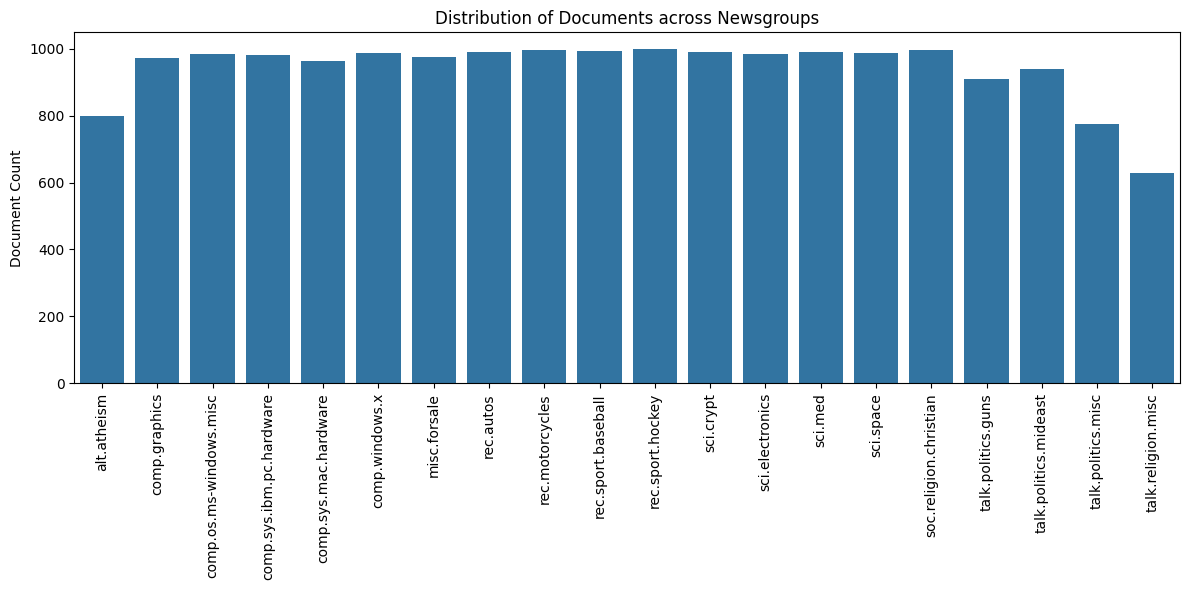

In [ ]:
label_counts = pd.Series(labels).value_counts().sort_index()
plt.figure(figsize=(12,6))
sns.barplot(x=label_names, y=label_counts.values)
plt.xticks(rotation=90)
plt.title("Distribution of Documents across Newsgroups")
plt.ylabel("Document Count")
plt.tight_layout()
plt.show()

5: Text Preprocessing

In [4]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(doc):
    doc = re.sub(r'[^a-zA-Z]', ' ', doc).lower()
    tokens = doc.split()
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 3]
    return ' '.join(tokens)

num_cores = multiprocessing.cpu_count()
processed_docs = Parallel(n_jobs=num_cores)(delayed(preprocess)(doc) for doc in documents)


6: TF-IDF Vectorization

In [5]:
vectorizer = TfidfVectorizer(max_features=2000)
X_tfidf = vectorizer.fit_transform(processed_docs)

7: KMeans Clustering for Topic Modeling

In [6]:
kmeans = KMeans(n_clusters=20, random_state=42)
kmeans_labels = kmeans.fit_predict(X_tfidf)
kmeans_score = silhouette_score(X_tfidf, kmeans_labels)
print("\nTop terms per KMeans cluster:")
terms = vectorizer.get_feature_names_out()
for i in range(20):
    top_terms = ", ".join([terms[ind] for ind in kmeans.cluster_centers_[i].argsort()[-10:][::-1]])
    print(f"Cluster {i}: {top_terms}")


Top terms per KMeans cluster:
Cluster 0: machine, configuration, byte, please, portable, documentation, compatible, defined, reach, quickly
Cluster 1: hockey, rather, better, thing, coverage, pittsburgh, devil, ranger, worst, score
Cluster 2: thanks, please, anyone, mail, know, would, advance, email, looking, address
Cluster 3: chip, clipper, encryption, key, phone, government, escrow, algorithm, would, system
Cluster 4: would, like, time, know, good, think, also, year, problem, well
Cluster 5: faith, saved, roman, christian, james, someone, know, hebrew, bother, teaching
Cluster 6: window, program, font, application, version, problem, thanks, running, using, driver
Cluster 7: people, would, think, christian, right, like, believe, know, time, jesus
Cluster 8: card, driver, video, monitor, window, color, mode, slot, graphic, thanks
Cluster 9: card, board, tried, svga, purchased, seemed, compatible, fairly, handle, fast
Cluster 10: article, statement, let, expansion, associated, newspap

8: Agglomerative Clustering

In [7]:
from sklearn.utils import resample

# Sample just 2000 rows for agglomerative
X_sample = X_tfidf[:2000].toarray()

# Re-run Agglomerative on this sample
agglom = AgglomerativeClustering(n_clusters=20)
agglom_labels = agglom.fit_predict(X_sample)
agglom_score = silhouette_score(X_sample, agglom_labels)

print(f"Agglomerative Clustering (Sample): {agglom_score:.4f}")


Agglomerative Clustering (Sample): 0.0056


9: DBSCAN Clustering

In [8]:
dbscan = DBSCAN(eps=1.2, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_tfidf)

# Silhouette Score only if DBSCAN found more than 1 cluster
if len(set(dbscan_labels)) > 1 and -1 in dbscan_labels:
    dbscan_score = silhouette_score(X_tfidf, dbscan_labels)
else:
    dbscan_score = None

10: Visualize KMeans Clusters using PCA

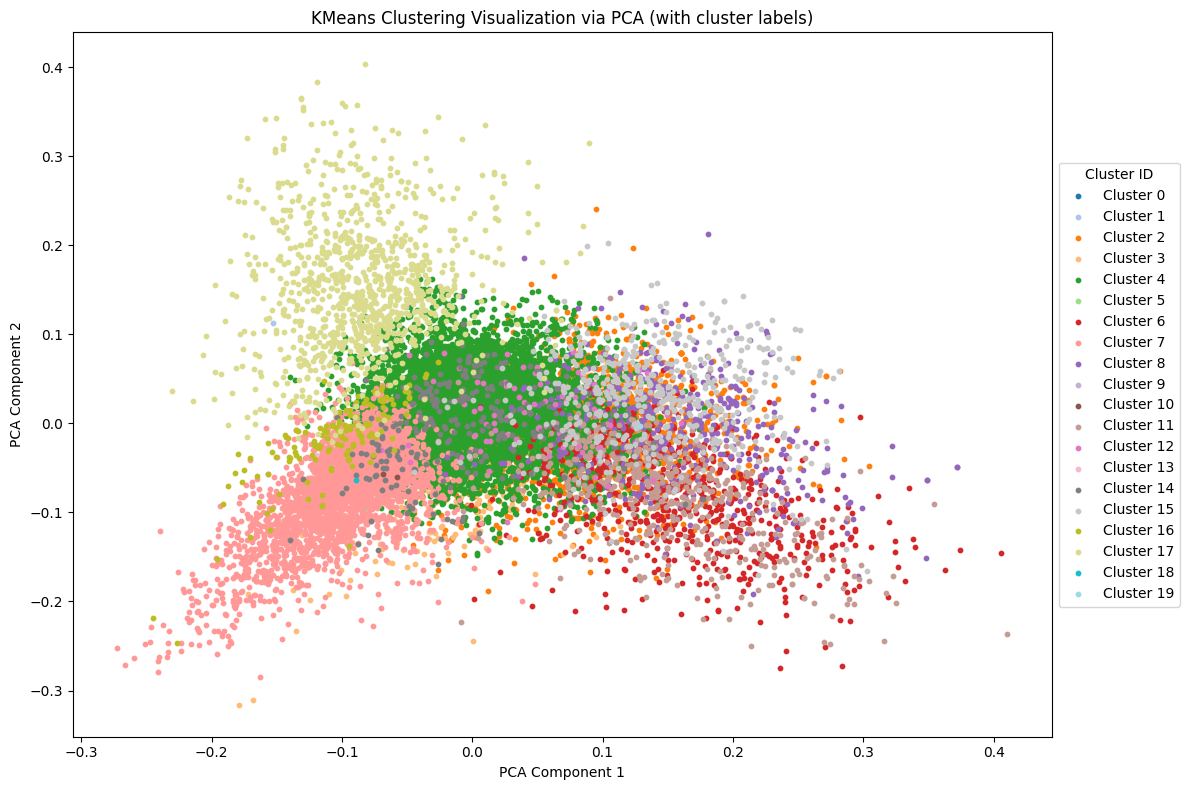

In [ ]:
from sklearn.decomposition import PCA

# Reduce TF-IDF matrix to 2D for visualization
X_pca = PCA(n_components=2, random_state=42).fit_transform(X_tfidf.toarray())

# Create a color palette for cluster labels
unique_clusters = np.unique(kmeans_labels)
palette = sns.color_palette('tab20', n_colors=len(unique_clusters))
label_colors = {label: palette[i] for i, label in enumerate(unique_clusters)}

# Plot each cluster with its assigned color
plt.figure(figsize=(12,8))
for label in unique_clusters:
    idx = np.where(kmeans_labels == label)
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1],
                color=label_colors[label], label=f"Cluster {label}", s=10)

plt.title("KMeans Clustering Visualization via PCA (with cluster labels)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Cluster ID")
plt.tight_layout()
plt.show()

11: Latent Dirichlet Allocation (LDA) for Topic Modeling

In [9]:
tokenized_texts = [doc.split() for doc in processed_docs]
dictionary = corpora.Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=20,
                                            random_state=42,
                                            passes=10)
print("\nLDA Topic Keywords:")
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {idx}: {topic}")


LDA Topic Keywords:
Topic 0: 0.032*"bike" + 0.026*"firearm" + 0.026*"weapon" + 0.017*"gun" + 0.014*"crime" + 0.013*"road" + 0.013*"license" + 0.012*"ride" + 0.011*"tire" + 0.010*"motorcycle"
Topic 1: 0.020*"chip" + 0.016*"encryption" + 0.013*"key" + 0.013*"security" + 0.012*"clipper" + 0.011*"government" + 0.011*"privacy" + 0.011*"phone" + 0.010*"public" + 0.010*"message"
Topic 2: 0.025*"file" + 0.022*"window" + 0.019*"image" + 0.013*"program" + 0.009*"version" + 0.008*"display" + 0.008*"color" + 0.008*"application" + 0.007*"using" + 0.007*"server"
Topic 3: 0.035*"drive" + 0.031*"card" + 0.023*"disk" + 0.021*"system" + 0.016*"driver" + 0.014*"scsi" + 0.012*"monitor" + 0.012*"board" + 0.011*"video" + 0.011*"software"
Topic 4: 0.031*"muslim" + 0.027*"cipher" + 0.019*"serb" + 0.016*"kent" + 0.015*"bosnia" + 0.014*"cheer" + 0.012*"bosnian" + 0.012*"callback" + 0.009*"goaltender" + 0.008*"latch"
Topic 5: 0.033*"please" + 0.033*"thanks" + 0.030*"anyone" + 0.030*"know" + 0.028*"would" + 0.01

12: LDA Visualization

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

13: WordClouds for LDA Topics

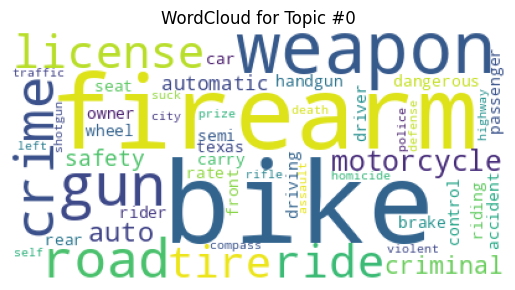

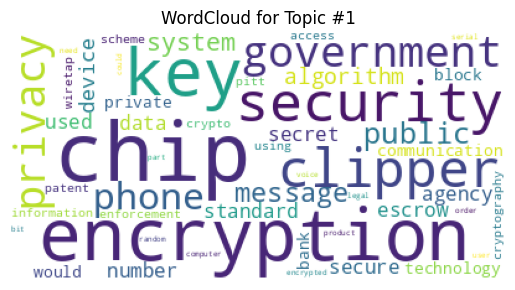

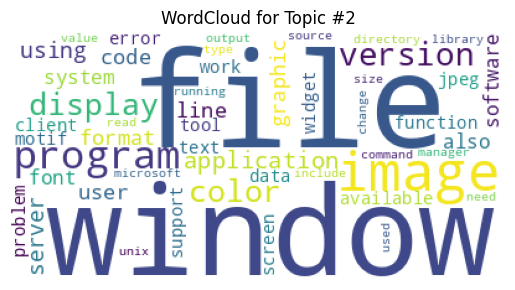

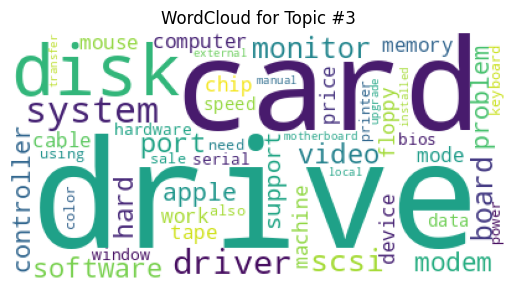

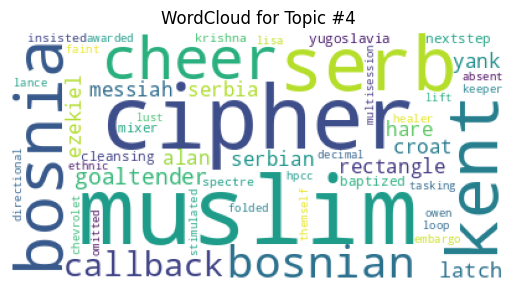

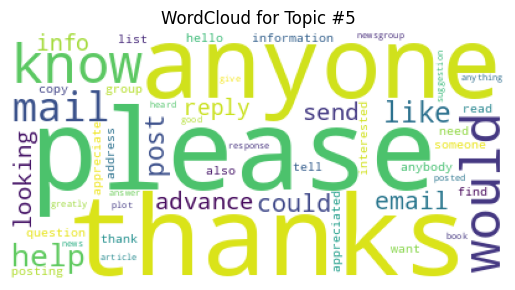

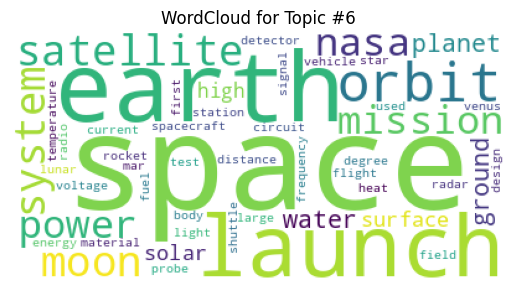

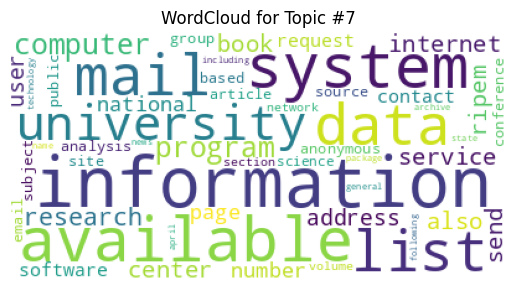

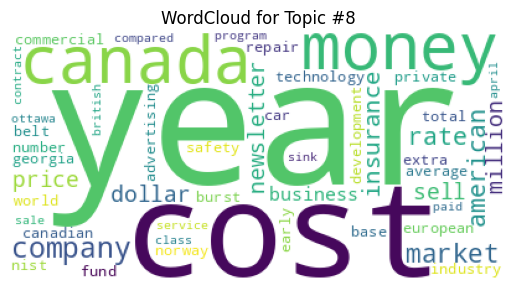

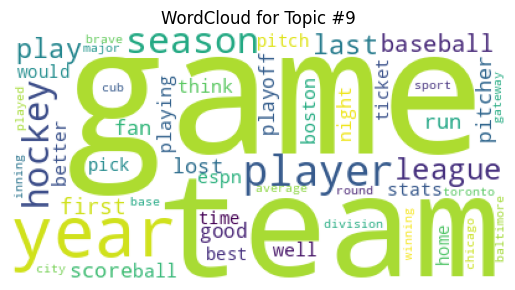

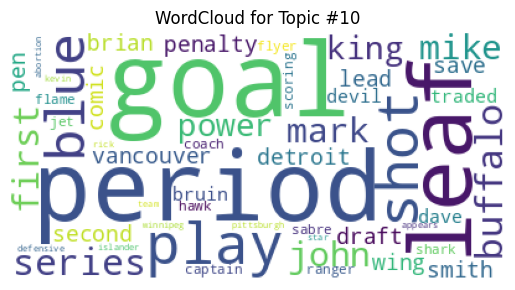

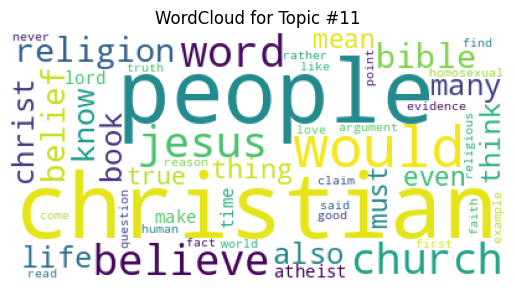

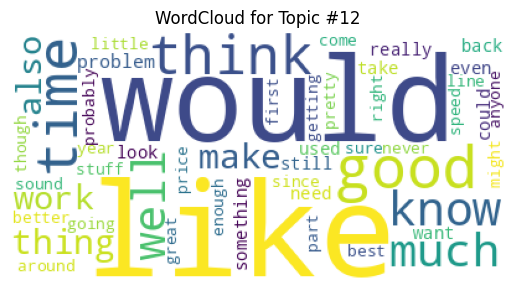

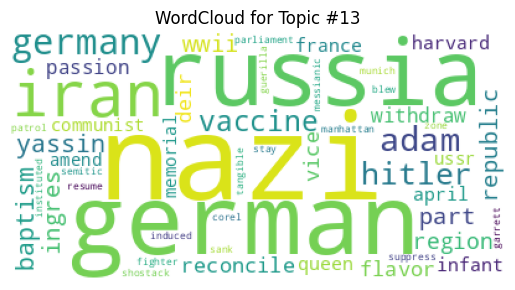

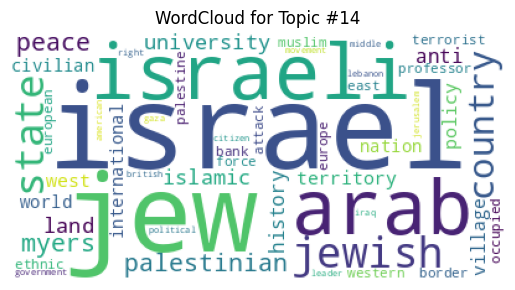

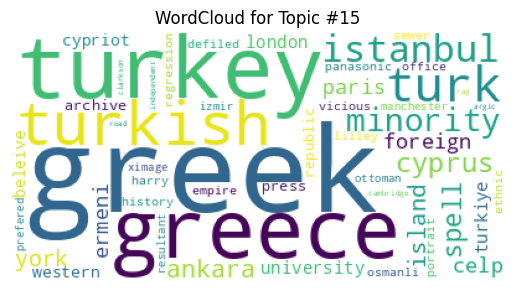

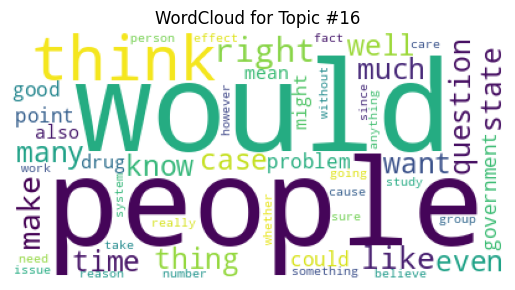

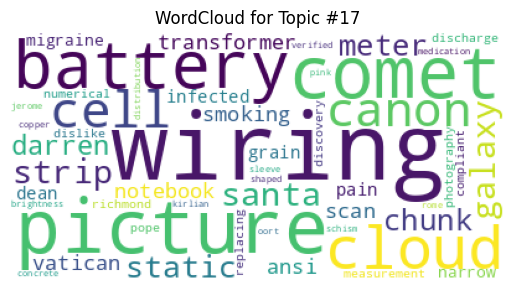

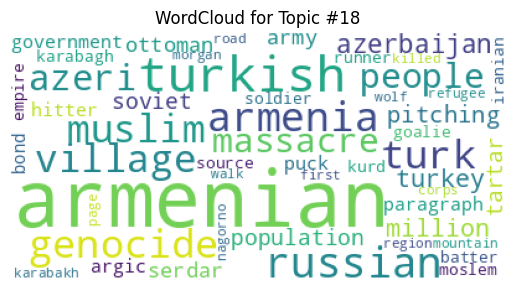

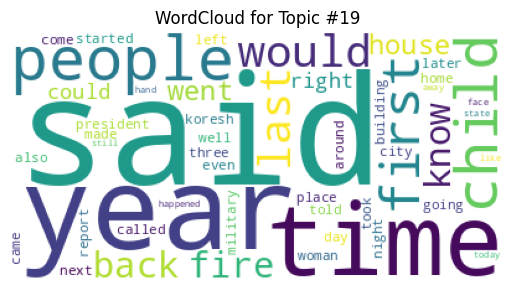

In [ ]:
for t in range(20):
    plt.figure()
    plt.imshow(WordCloud(background_color='white').fit_words(dict(lda_model.show_topic(t, 50))))
    plt.axis("off")
    plt.title(f"WordCloud for Topic #{t}")
    plt.show()

14: Clustering Model Comparison

In [10]:
# Step 14: Clustering Model Comparison
print("Silhouette Scores:")
print(f"KMeans: {kmeans_score:.4f}")
print(f"Agglomerative Clustering: {agglom_score:.4f}")
if dbscan_score is not None:
    print(f"DBSCAN: {dbscan_score:.4f}")
else:
    print("DBSCAN: Not applicable (only one cluster found)")


Silhouette Scores:
KMeans: -0.0053
Agglomerative Clustering: 0.0056
DBSCAN: Not applicable (only one cluster found)


15: Save Models/Data in .ipynb

In [11]:
import joblib
joblib.dump(kmeans, "kmeans_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(X_tfidf, "tfidf_matrix.pkl")


['tfidf_matrix.pkl']

16: Load Them in app.py

In [12]:
import joblib
kmeans = joblib.load("kmeans_model.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")
X = joblib.load("tfidf_matrix.pkl")
